Let's train the guy

In [1]:
import tensorflow as tf
import pandas as pd
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm as tqdm
tf.keras.backend.set_floatx('float32')
from collections import deque
from datetime import datetime
import random
import matplotlib
from environment import Environment
from plots import just_plot
from misc import *
from nets import *
from buffer import ReplayBuffer


amplitude=0.4
tau = 0.1
lr_critic = 0.005
lr_actor=10**-5
noise_displacement = .25
ep_guess=0.01
dolinar_layers=1
number_phases=2
buffer_size = 10**7


env = Environment(amplitude=amplitude, dolinar_layers = dolinar_layers, number_phases=number_phases)
buffer = ReplayBuffer(buffer_size=buffer_size)

critic = Critic(nature="primary",valreg=0.0, dolinar_layers = dolinar_layers, number_phases=number_phases)
critic_target = Critic(nature="target", valreg=0.0,dolinar_layers = dolinar_layers, number_phases=number_phases, tau = tau)
actor = Actor(nature="primary",valreg=0.0, dolinar_layers = dolinar_layers)
actor_target = Actor(nature="target",valreg=0.0, dolinar_layers = dolinar_layers)

optimizer_critic = tf.keras.optimizers.Adam(lr=lr_critic)
optimizer_actor = tf.keras.optimizers.SGD(lr=lr_actor)

policy_evaluator = PolicyEvaluator(amplitude = amplitude, dolinar_layers=dolinar_layers, number_phases = number_phases)

expes = np.load("buffers/1L-stoch.npy")

for k in tqdm(expes):
    buffer.add(tuple(k))

def plot(critic, episode = 1, last_episode=False, max_episode=10**4, history_betas =[]):

    betas = np.arange(.1,1.1,.05)
    inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
    inps = np.reshape(inps, (len(betas),1,2))
    ax3.plot(betas, np.squeeze(critic(inps)), alpha=min(episode/max_episode,1), linewidth=5,label="RNN - "+str(episode))

    for outcome in [0.,1.]:
       for guess_index in [0.,1.]:
            m=[]
            for k in tf.unstack(inps):
                m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
            axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1], alpha=min(episode/max_episode,1), linewidth=5,label="RNN" +str(episode))
            
            
    if last_episode:
        betas = np.arange(.1,1.1,.05)
        inps = np.stack([np.ones(len(betas))*critic.pad_value, betas], axis=1)
        inps = np.reshape(inps, (len(betas),1,2))
        ax3.plot(betas, np.squeeze(critic(inps)), linewidth=8,c="black",label="RNN")


        for outcome in [0.,1.]:
           for guess_index in [0.,1.]:
                m=[]
                for k in tf.unstack(inps):
                    m.append(tf.concat([k, np.reshape(np.array([outcome,guess_index]), (1,2))], axis=0))
                axes[str(outcome)].plot(betas, np.squeeze(critic(tf.stack(m, axis=0)))[:,1],c="black", linewidth=8,label="RNN")


        ax1.plot(betas,[qval(b, 0, -1) for b in betas],c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax1.plot(betas,[qval(b, 0, 1) for b in betas],c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

        ax2.plot(betas,[qval(b, 1, -1) for b in betas],c="red", linewidth=5, label="Q(n1=0,"+r'$\beta$'+"; g=-1)")
        ax2.plot(betas,[qval(b, 1, 1) for b in betas],c="blue",  linewidth=5,label="Q(n1=0,"+r'$\beta$'+"; g=1)")

        ax3.plot(betas,ps_maxlik(betas), '--', linewidth=5, color="red", label="P*")
        ax4.plot(np.arange(1,len(history_betas)+1), history_betas, alpha=0.75, c="red", linewidth=7)
        for ax in [ax1, ax2, ax3]:
            ax.set_xlabel(r'$\beta$', size=20)


100%|██████████| 5000/5000 [00:00<00:00, 542923.86it/s]


In [2]:

loss_ev = []
history_betas = []
total_episodes = 10**3
batch_size = 128.           

context_outcome_actor = np.reshape(np.array([actor.pad_value]),(1,1,1)).astype(np.float32)
history_betas.append(np.squeeze(actor(context_outcome_actor)[0]))
   

In [3]:
history_betas

[array(0.00066914, dtype=float32)]

In [4]:
varactor = actor.trainable_variables

  0%|          | 1/1000 [00:12<3:26:31, 12.40s/it]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



100%|██████████| 1000/1000 [00:41<00:00, 24.32it/s]


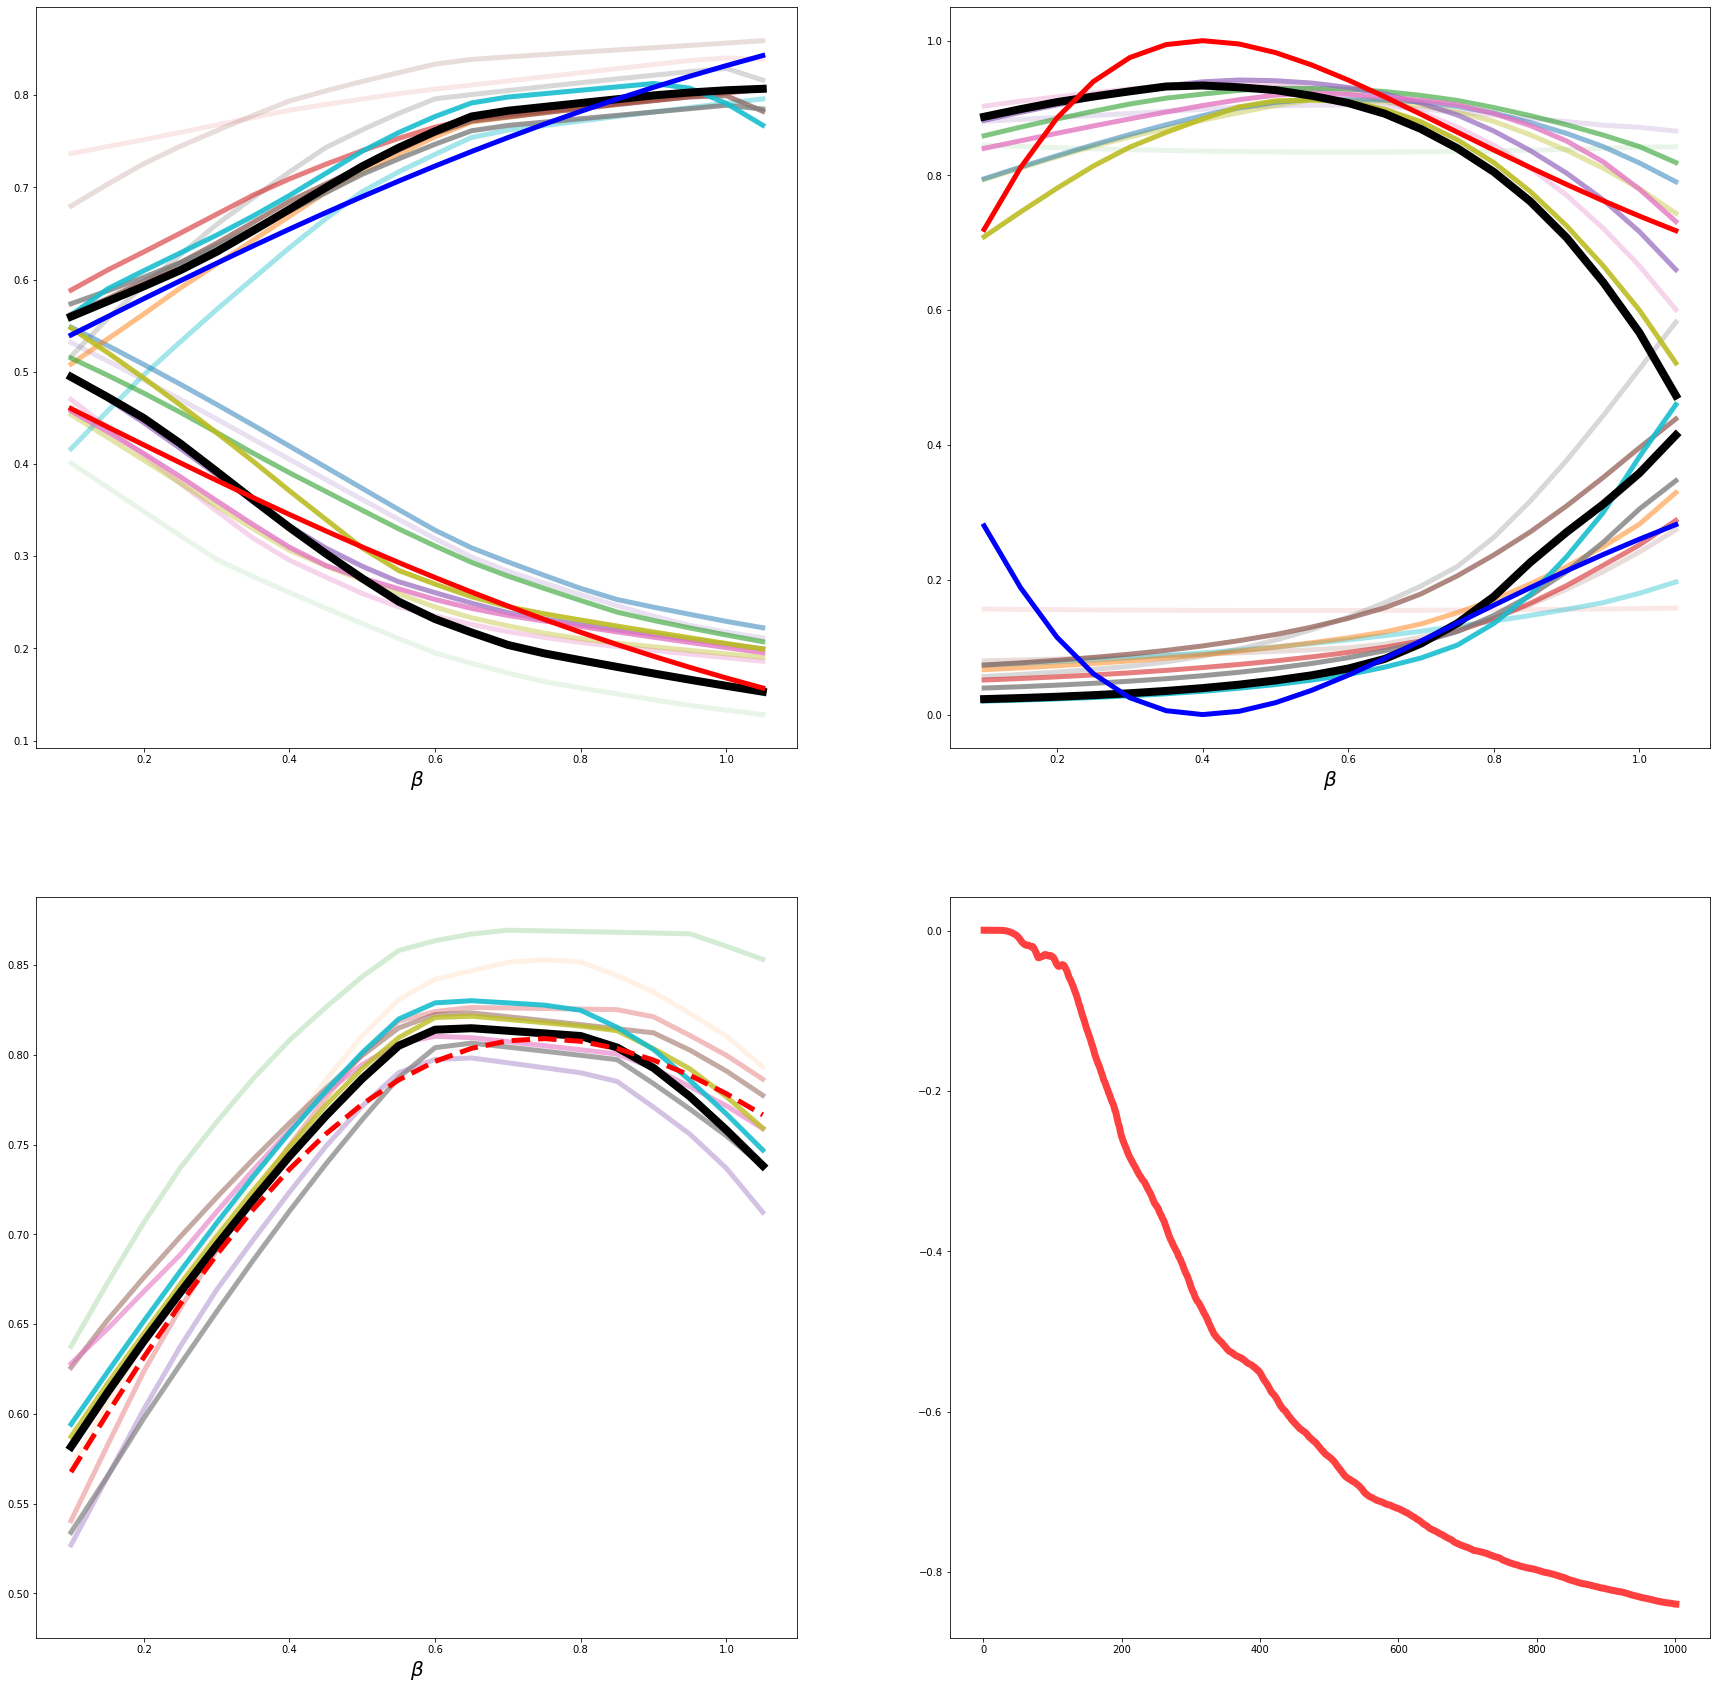

In [5]:
plt.figure(figsize=(30,30))


ax1 = plt.subplot2grid((2,2),(0,0))
ax2 = plt.subplot2grid((2,2),(0,1))
ax3 = plt.subplot2grid((2,2),(1,0))
ax4 = plt.subplot2grid((2,2),(1,1))

axes = {"0.0":ax1, "1.0":ax2}


for k in tqdm(range(10**3)):
    experiences = buffer.sample(batch_size).astype(np.float32)
    samples, zerolabs = critic_target.process_sequence_tf(experiences)
    labels_critic = critic_target.give_td_errors_tf( samples, zerolabs)
    loss_critic = step_critic_tf(samples ,labels_critic, critic, optimizer_critic)
    critic_target.update_target_parameters(critic)
    loss_ev.append(loss_critic.numpy())
    #### actor ####
    
    actor.lstm.stateful=False
    actor.reset_states_workaround(new_batch_size=int(batch_size))
    
    dq_da = critic_grad_tf(critic, experiences)
    actor_grad_tf(actor, dq_da, experiences, optimizer_actor)
    
    actor.reset_states_workaround(new_batch_size=1)
    actor.lstm.stateful=True

    context_outcome_actor = np.reshape(np.array([actor.pad_value]),(1,1,1)).astype(np.float32)
    history_betas.append(np.squeeze(actor(context_outcome_actor)[0]))
    
    if k%int(total_episodes/10)==1:
        plot(critic, episode=k, last_episode=False, max_episode = total_episodes)
plot(critic, episode=k, last_episode=True, history_betas=history_betas)    

Let0s analyze critic graddient

In [ ]:

dq_da = critic_grad_tf(critic, experiences)
actor_grad_tf(actor, dq_da, experiences, optimizer_actor)


In [9]:
experiences.shape

(128, 4)

In [10]:
def critic_grad_tf(critic, experiences):
    with tf.GradientTape() as tape:
        unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
        to_stack = []
        actions_wathed_index = []
        for index in range(0,experiences.shape[-1]-3,2): # I consider from first outcome to last one (but guess)
            actions_wathed_index.append(index)
            to_stack.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

        actions_indexed = tf.concat(to_stack,axis=1)
        tape.watch(actions_indexed)

        index_actions=0
        watched_exps=[tf.ones((experiences.shape[0],1,1))*critic.pad_value]
        watched_actions_unstacked = tf.unstack(actions_indexed, axis=1)
        for index in range(0,experiences.shape[-1]-1):
            if index in actions_wathed_index:
                watched_exps.append(tf.expand_dims(watched_actions_unstacked[index_actions], axis=2))
                index_actions+=1
            else:
                watched_exps.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

        qvals = critic(tf.reshape(tf.concat(watched_exps, axis=2), (experiences.shape[0],critic.dolinar_layers+1,2)))

        dq_da = tape.gradient(qvals, actions_indexed)
        #tf.print("dq_da mean", tf.math.reduce_mean(dq_da))
        return dq_da


In [11]:
critic_grad_tf(critic, experiences)

<tf.Tensor: shape=(128, 1, 1), dtype=float32, numpy=
array([[[ 0.08007786]],

       [[ 0.05323435]],

       [[-0.2505908 ]],

       [[ 0.18125424]],

       [[-0.0986543 ]],

       [[-0.11254521]],

       [[ 0.9445448 ]],

       [[ 0.18125424]],

       [[ 1.0275904 ]],

       [[-1.4415551 ]],

       [[ 0.63472223]],

       [[ 0.63472223]],

       [[ 0.5903304 ]],

       [[ 1.0275904 ]],

       [[-0.16604269]],

       [[ 0.05420278]],

       [[ 0.5903304 ]],

       [[-0.2459273 ]],

       [[-0.09426881]],

       [[-0.517096  ]],

       [[ 0.18125424]],

       [[ 0.08007786]],

       [[-0.2459273 ]],

       [[ 0.49426877]],

       [[ 0.9445448 ]],

       [[ 0.58286923]],

       [[ 0.29090685]],

       [[-1.4415551 ]],

       [[-0.53396356]],

       [[-0.1769408 ]],

       [[ 0.6105687 ]],

       [[-2.2128458 ]],

       [[ 0.9445448 ]],

       [[-0.09426881]],

       [[-0.38781512]],

       [[ 1.0275904 ]],

       [[-0.1769408 ]],

       [[-0.2459273 ]]

In [13]:
experiences = experiences[:5]

with tf.GradientTape() as tape:
    unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
    to_stack = []
    actions_wathed_index = []
    for index in range(0,experiences.shape[-1]-3,2): # I consider from first outcome to last one (but guess)
        actions_wathed_index.append(index)
        to_stack.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))
    actions_indexed = tf.concat(to_stack,axis=1)
    tape.watch(actions_indexed)

In [15]:
experiences

array([[0.2, 0. , 0. , 1. ],
       [0.8, 0. , 1. , 1. ],
       [0.7, 0. , 0. , 1. ],
       [0.1, 0. , 0. , 0. ],
       [0.4, 0. , 0. , 0. ]], dtype=float32)

In [14]:
actions_indexed

<tf.Tensor: shape=(5, 1, 1), dtype=float32, numpy=
array([[[0.2]],

       [[0.8]],

       [[0.7]],

       [[0.1]],

       [[0.4]]], dtype=float32)>

In [19]:
experiences = experiences[:5]

with tf.GradientTape() as tape:
    unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
    to_stack = []
    actions_wathed_index = []
    for index in range(0,experiences.shape[-1]-3,2): # I consider from first outcome to last one (but guess)
        actions_wathed_index.append(index)
        to_stack.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))
    actions_indexed = tf.concat(to_stack,axis=1)
    tape.watch(actions_indexed)

    index_actions=0
    watched_exps=[tf.ones((experiences.shape[0],1,1))*critic.pad_value]
    watched_actions_unstacked = tf.unstack(actions_indexed, axis=1)
    for index in range(0,experiences.shape[-1]-1):
        if index in actions_wathed_index:
            watched_exps.append(tf.expand_dims(watched_actions_unstacked[index_actions], axis=2))
            index_actions+=1
        else:
            watched_exps.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

    qvals = critic(tf.reshape(tf.concat(watched_exps, axis=2), (experiences.shape[0],critic.dolinar_layers+1,2)))

In [20]:
qvals

<tf.Tensor: shape=(5, 2, 1), dtype=float32, numpy=
array([[[0.64052504],
        [0.44974178]],

       [[0.8105484 ],
        [0.79139924]],

       [[0.81348574],
        [0.20381853]],

       [[0.581708  ],
        [0.49446815]],

       [[0.74352187],
        [0.33122364]]], dtype=float32)>

In [24]:
critic(critic.process_sequence(experiences)[0]) - qvals

<tf.Tensor: shape=(5, 2, 1), dtype=float32, numpy=
array([[[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]],

       [[0.],
        [0.]]], dtype=float32)>

In [25]:
experiences = experiences[:5]

with tf.GradientTape() as tape:
    unstacked_exp = tf.unstack(tf.convert_to_tensor(experiences), axis=1)
    to_stack = []
    actions_wathed_index = []
    for index in range(0,experiences.shape[-1]-3,2): # I consider from first outcome to last one (but guess)
        actions_wathed_index.append(index)
        to_stack.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))
    actions_indexed = tf.concat(to_stack,axis=1)
    tape.watch(actions_indexed)

    index_actions=0
    watched_exps=[tf.ones((experiences.shape[0],1,1))*critic.pad_value]
    watched_actions_unstacked = tf.unstack(actions_indexed, axis=1)
    for index in range(0,experiences.shape[-1]-1):
        if index in actions_wathed_index:
            watched_exps.append(tf.expand_dims(watched_actions_unstacked[index_actions], axis=2))
            index_actions+=1
        else:
            watched_exps.append(tf.reshape(unstacked_exp[index],(experiences.shape[0],1,1)))

    qvals = critic(tf.reshape(tf.concat(watched_exps, axis=2), (experiences.shape[0],critic.dolinar_layers+1,2)))
    dq_da = tape.gradient(qvals, actions_indexed)
    

In [26]:
dq_da

<tf.Tensor: shape=(5, 1, 1), dtype=float32, numpy=
array([[[ 0.0800779 ]],

       [[ 0.05323435]],

       [[-0.25059077]],

       [[ 0.18125427]],

       [[-0.09865434]]], dtype=float32)>

Vale, it makes what we want, \grad_a Q(s,a).

Let's look the last one

In [100]:
exxp = experiences[:3]
actor.reset_states_workaround(new_batch_size=3)
with tf.GradientTape() as tape1:
    tape.watch(actor.trainable_variables)
    finns = [tf.ones((exxp.shape[0], 1,1))*actor.pad_value]
    unstacked_exp = tf.unstack(exxp, axis=1)
    for index in range(1,2*actor.dolinar_layers-2,2):
        finns.append(tf.reshape(unstacked_exp[index], (exxp.shape[0], 1,1)))
    final_preds = tf.concat(finns, axis=1)
    final_predss = actor(final_preds)
    da_dtheta1 = tape1.jacobian(final_predss, actor.trainable_variables)
    #da_dtheta=tape.gradient(final_preds, actor.trainable_variables, output_gradients=-dq_da)
    #tf.print("dq_dtheta mean", [tf.math.reduce_mean(k).numpy() for k in da_dtheta])
   # optimizer_actor.apply_gradients(zip(da_dtheta, actor.trainable_variables))
    #return



ValueError: Tape is still recording, This can happen if you try to re-enter an already-active tape.

In [95]:
len(da_dtheta1)

7

In [91]:
for k in da_dtheta:
    print(k.shape)

(1, 1000)
(250, 1000)
(1000,)
(250, 30)
(30,)
(30, 1)
(1,)


In [59]:
for k in da_dtheta:
    print(k.shape)

(1, 1000)
(250, 1000)
(1000,)
(250, 30)
(30,)
(30, 1)
(1,)
